In [63]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [47]:
#importing necessary libraries for the project

import os
import numpy as np
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import pytesseract
from pytesseract import image_to_string
import pandas as pd
from PIL import Image

In [30]:
# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Load images from folder

def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            print(f"Loaded image {filename} with original size: {img.shape}")
            images.append(img)
        else:
            print(f"Warning: Could not load image {filename}")
    return images


In [39]:

# Resize images to a common size
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        resized_images.append(resized_img)
    return resized_images

folder_path = '/content/drive/MyDrive/denoising-dirty-documents/train/train'


In [8]:
# Load and resize images
train_images = load_images(folder_path)
target_size = (540, 420)  # Adjust to a fixed size
train_images = resize_images(train_images, target_size)

print(f"Loaded and resized {len(train_images)} images from {folder_path}")


Loaded and resized 144 images from /content/drive/MyDrive/denoising-dirty-documents/train/train


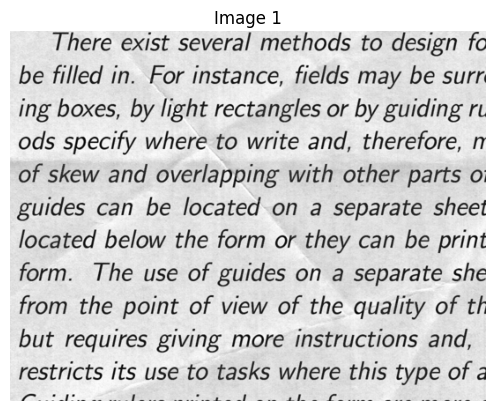

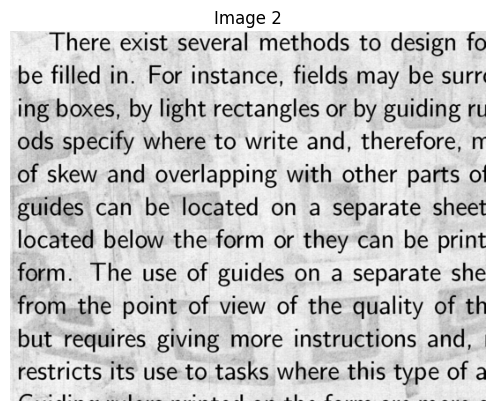

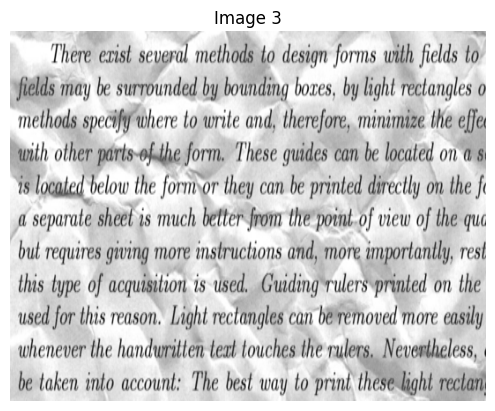

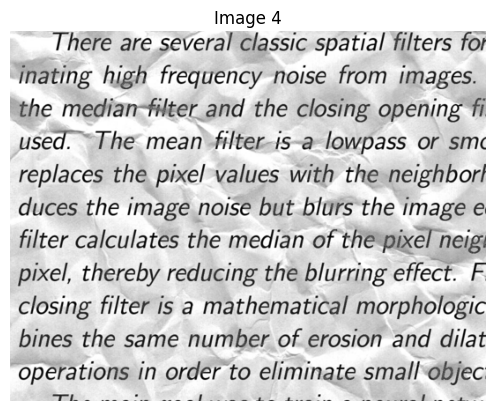

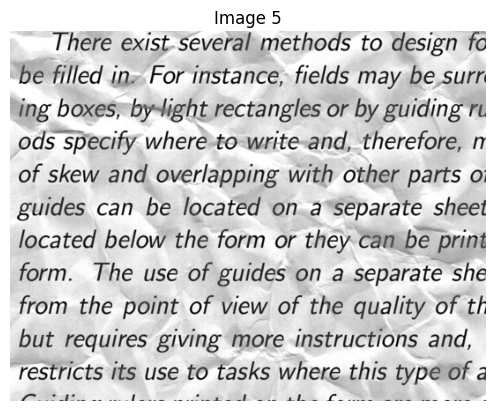

In [9]:
#displaying some training imgs

for i in range(min(5, len(train_images))):
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()

In [10]:
# Perform SVD-based denoising
def svd_dirty_docs(images, k):
    denoised_imgs = []
    for img in images:
        U, S, Vt = np.linalg.svd(img, full_matrices=True)
        S_k = np.zeros((k, k))
        S_k[:k, :k] = np.diag(S[:k])
        U_k = U[:, :k]
        Vt_k = Vt[:k, :]
        denoised_img = np.dot(U_k, np.dot(S_k, Vt_k))
        denoised_img = np.clip(denoised_img, 0, 255)
        denoised_imgs.append(denoised_img)
    return denoised_imgs

**Peak Signal to Noise Ration (PSNR) calculation**

In [14]:
# function for psnr calculation 

def calculate_psnr_value(denoised_imgs, images):
    psnr_values = []
    for d_img, o_img in zip(images, denoised_imgs):
        mse = np.mean((o_img - d_img) ** 2)
        if mse == 0:
            psnr_values.append(100)
        else:
            pix_max = 255.0
            psnr = 20 * log10(pix_max / sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

psnr = calculate_psnr_value(denoised_imgs, train_images)
print("The PSNR value for denoised and original documents:", psnr, "dB")

The PSNR value for denoised and original documents: 41.03948567992711 dB


**Structural Similarity Index (SSIM) calculation**

In [15]:
from skimage.metrics import structural_similarity as calculate_ssim

# function for ssim calculation 
def calculate_ssim_value(denoised_imgs, images):
    ssim_values = []
    for o_img, d_img in zip(images, denoised_imgs):
        ssim_val = calculate_ssim(o_img, d_img, data_range=255)
        ssim_values.append(ssim_val)
    return np.mean(ssim_values)

ssim = calculate_ssim_value(denoised_imgs, train_images)
print("The SSIM value for denoised and original documents:", ssim)

The SSIM value for denoised and original documents: 0.9724274987910869


**Mean Squared Error (MSE) calculation**

In [16]:
# function for mse calculation

def calculate_mse(original_images, denoised_images):
    mse_values = []
    for original, denoised in zip(original_images, denoised_images):
        mse = np.mean((original - denoised) ** 2)
        mse_values.append(mse)
    return np.mean(mse_values)


mse = calculate_mse(train_images, denoised_imgs)
print(f"Mean Squared Error (MSE) between denoised and original documents: {mse}")


Mean Squared Error (MSE) between denoised and original documents: 8.148355024132476


In [40]:
k_values = [50, 100, 150, 180, 200,250,300,320,350,360,370,380,390]

print("k Value | MSE       | PSNR (dB) | SSIM")
print("--------------------------------------------")
for k in k_values:
    denoised_imgs = svd_dirty_docs(train_images, k)
    mse = calculate_mse(train_images, denoised_imgs)
    psnr = calculate_psnr_value(denoised_imgs, train_images)
    ssim = calculate_ssim_value(denoised_imgs, train_images)
    print(f"{k:<7} | {mse:.4f} | {psnr:.4f} | {ssim:.4f}")


k Value | MSE       | PSNR (dB) | SSIM
--------------------------------------------
50      | 288.7553 | 23.9059 | 0.7568
100     | 66.6821 | 30.7691 | 0.8830
150     | 17.4008 | 37.2985 | 0.9516
180     | 8.1484 | 41.0395 | 0.9724
200     | 5.0049 | 43.5865 | 0.9811
250     | 1.5310 | 50.8968 | 0.9928
300     | 0.4509 | 56.4353 | 0.9975
320     | 0.2622 | 58.6087 | 0.9984
350     | 0.1035 | 62.3923 | 0.9993
360     | 0.0722 | 63.8739 | 0.9995
370     | 0.0485 | 65.5248 | 0.9997
380     | 0.0308 | 67.4185 | 0.9998
390     | 0.0180 | 69.6772 | 0.9999


In [41]:
# testing it out keeping k =180

k = 300
denoised_imgs = svd_dirty_docs(train_images, k)

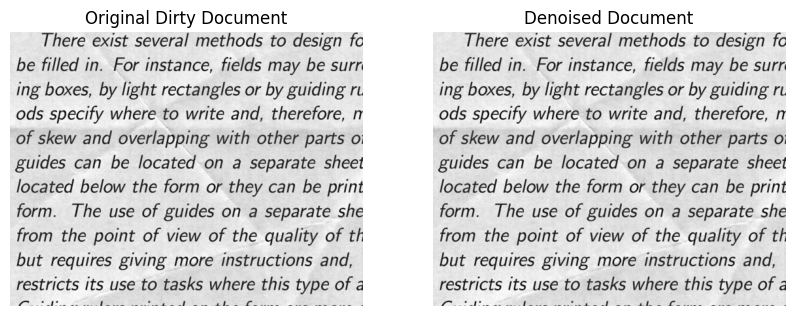

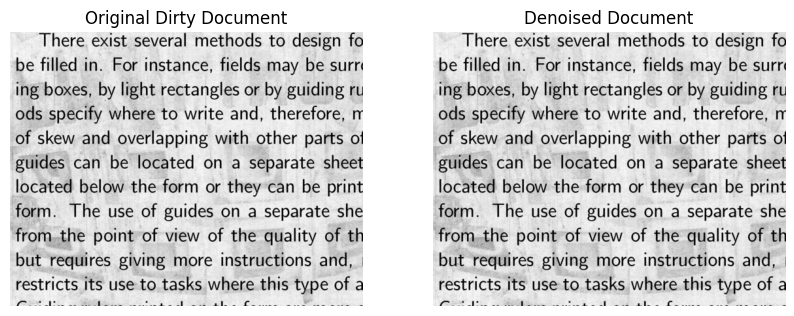

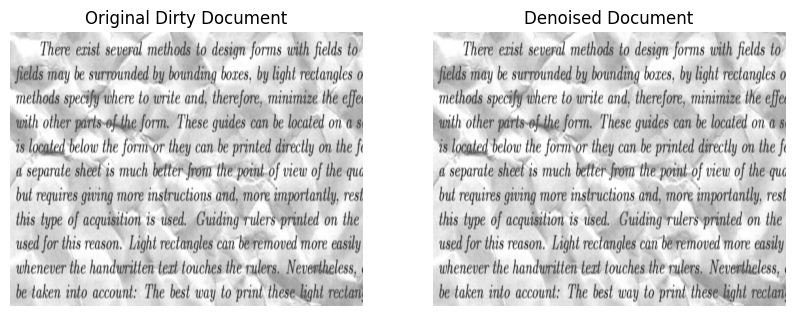

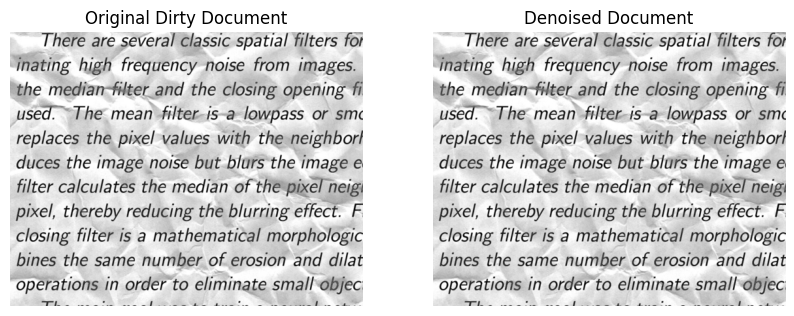

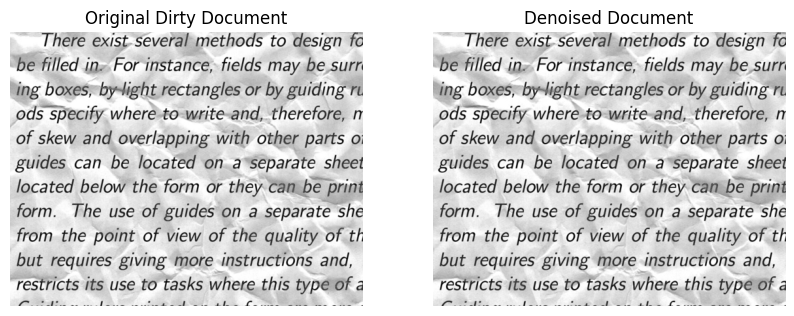

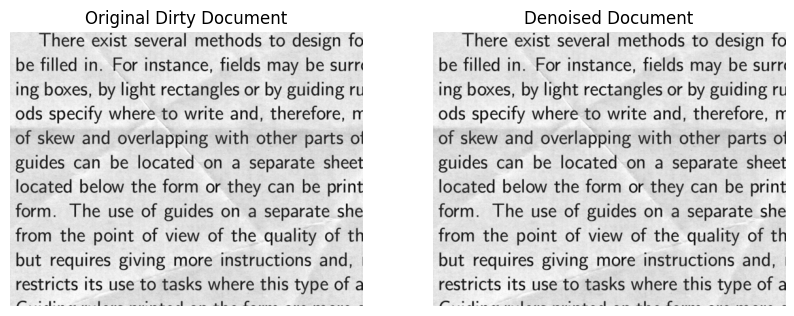

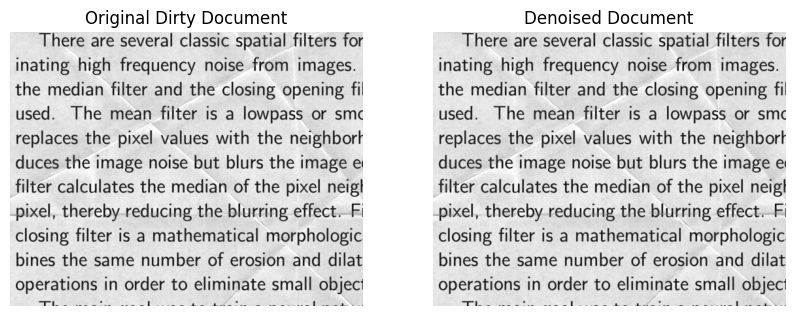

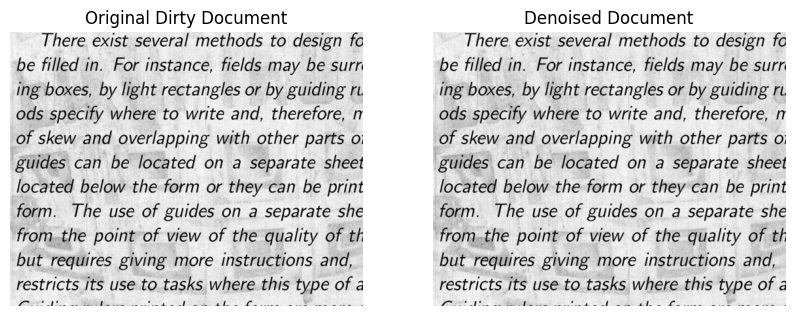

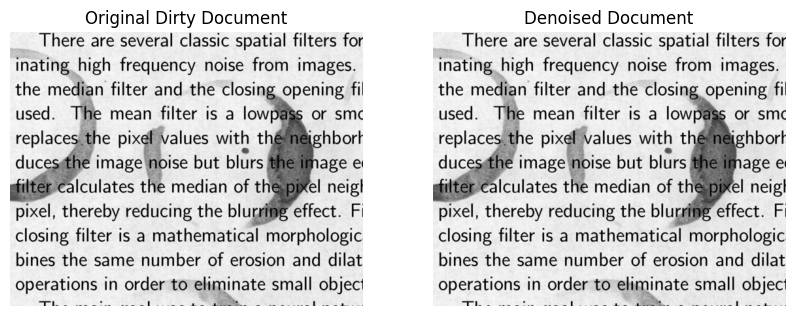

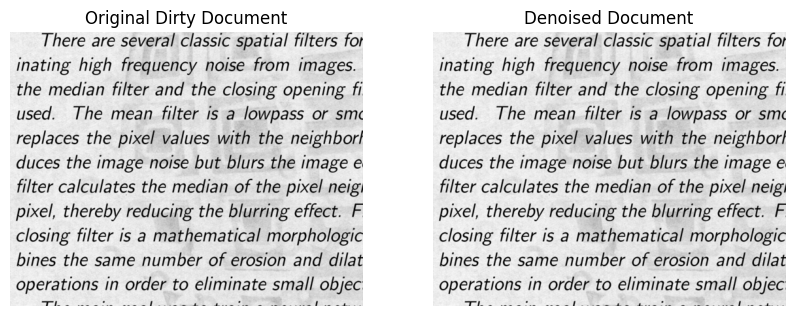

In [42]:
# displaying original and denoised documents

for i in range(min(10, len(train_images))):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title("Original Dirty Document")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_imgs[i], cmap='gray')
    plt.title("Denoised Document")
    plt.axis('off')

    plt.show()

In [55]:
# function to apply Non-Local Means (NLM) denoising to a list of images

def non_local_means_denoising(images):
    denoised_imgs = []
    for img in images:
        denoised_img = cv2.fastNlMeansDenoising(img, None, h=30, templateWindowSize=7, searchWindowSize=21)
        denoised_imgs.append(denoised_img)
    return denoised_imgs


nlm_denoised_imgs = non_local_means_denoising(train_images)


In [57]:
# function to apply Gaussian Filtering to a list of images

def gaussian_filtering(images, kernel_size=(5, 5), sigma=1):
    denoised_imgs = []
    for img in images:
        denoised_img = cv2.GaussianBlur(img, kernel_size, sigma)
        denoised_imgs.append(denoised_img)
    return denoised_imgs

gaussian_denoised_imgs = gaussian_filtering(train_images)


In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

#function to build a simple convolutional autoencoder model
def build_autoencoder(input_shape):
    # Encoder: Compresses the input into a lower-dimensional representation
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder: Reconstructs the image from the compressed representation
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Combine encoder and decoder into the autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

# normalize images to range [0, 1] for better training stability
train_images_normalized = np.array(train_images) / 255.0  

# reshape images to add a channel dimension 
train_images_reshaped = np.expand_dims(train_images_normalized, axis=-1)  

# building the autoencoder model with input shape matching the training images
autoencoder = build_autoencoder(input_shape=(train_images[0].shape[0], train_images[0].shape[1], 1))

# compile the autoencoder with MSE loss and Adam optimizer
autoencoder.compile(optimizer='adam', loss='mse')

#fit the autoencoder using training images
autoencoder.fit(train_images_reshaped, train_images_reshaped, epochs=10, batch_size=16, shuffle=True)

# use the trained autoencoder to denoise images
autoencoder_denoised_imgs = autoencoder.predict(train_images_reshaped)

# remove the channel dimension and scale back to pixel values [0, 255]
autoencoder_denoised_imgs = (autoencoder_denoised_imgs.squeeze() * 255).astype(np.uint8)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 99s 10s/step - loss: 0.1154
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 133s 10s/step - loss: 0.0539
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 87s 10s/step - loss: 0.0471
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - loss: 0.0453
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - loss: 0.0419
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - loss: 0.0386
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - loss: 0.0357
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - loss: 0.0317
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 141s 10s/step - loss: 0.0299
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 154s 10s/step - loss: 0.0292
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


In [59]:
from skimage.metrics import structural_similarity as calculate_ssim

#function to evaluate the quality of denoising using MSE, PSNR, and SSIM metrics
def evaluate_denoising(original_images, denoised_images):
    mse = np.mean([np.mean((orig - den) ** 2) for orig, den in zip(original_images, denoised_images)])
    psnr = 20 * log10(255.0 / sqrt(mse))
    ssim_values = [calculate_ssim(orig, den, data_range=255) for orig, den in zip(original_images, denoised_images)]
    avg_ssim = np.mean(ssim_values)
    return mse, psnr, avg_ssim


In [62]:
#evaluate the denoising performance of different methods using the evaluation function

nlm_metrics = evaluate_denoising(train_images, nlm_denoised_imgs)
gaussian_metrics = evaluate_denoising(train_images, gaussian_denoised_imgs)
autoencoder_metrics = evaluate_denoising(train_images, autoencoder_denoised_imgs)

# Print results
print("Method          | MSE       | PSNR (dB) | SSIM")
print("--------------------------------------------------")
print(f"SVD             | 0.4509| 56.4353 | 0.9975")
print(f"Non-Local Means | {nlm_metrics[0]:.4f} | {nlm_metrics[1]:.4f} | {nlm_metrics[2]:.4f}")
print(f"Gaussian Filter | {gaussian_metrics[0]:.4f} | {gaussian_metrics[1]:.4f} | {gaussian_metrics[2]:.4f}")
print(f"Autoencoder     | {autoencoder_metrics[0]:.4f} | {autoencoder_metrics[1]:.4f} | {autoencoder_metrics[2]:.4f}")


Method          | MSE       | PSNR (dB) | SSIM
--------------------------------------------------
SVD             | 0.4509| 56.4353 | 0.9975
Non-Local Means | 37.4981 | 32.3907 | 0.8457
Gaussian Filter | 44.6606 | 31.6316 | 0.8480
Autoencoder     | 84.6827 | 28.8529 | 0.4205


**Optical Character Recognition**

In [44]:
#function to perform Optical Character Recognition (OCR) on a list of images

def perform_ocr(images):
    ocr_results = []
    for img in images:
        text = pytesseract.image_to_string(img, config='--psm 6') 
        ocr_results.append(text)
    return ocr_results

**Saving denoised images from floating point to images**

In [52]:
#function to save a single image to a specified file path
def save_image(img, file_path):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255)
        img = img.astype(np.uint8)
    Image.fromarray(img).save(file_path)

output_folder = '/content/denoised_images'
os.makedirs(output_folder, exist_ok=True)


# Iterate through train_images and save the corresponding denoised images
# Iterate through the original filenames and save the corresponding denoised images
original_filenames = sorted(os.listdir(folder_path))

for i, filename in enumerate(original_filenames):
    save_image(denoised_imgs[i], f'{output_folder}/{filename}')


print(f"All images saved to {output_folder}")


All images saved to /content/denoised_images


In [53]:
#function to load all saved images from a specified folder

def load_saved_images(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):  # Sort for consistent order
        file_path = os.path.join(folder_path, filename)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            images.append(img)
        else:
            print(f"Warning: Could not load image {filename}")
    return images

denoised_folder = '/content/denoised_images'

denoised_imgs_loaded = load_saved_images(denoised_folder)

In [54]:
# perform OCR on the first 10 noisy images from the training dataset
noisy_ocr_results = perform_ocr(train_images[:10])
# perform OCR on the first 10 denoised images loaded from the saved folder
denoised_ocr_results = perform_ocr(denoised_imgs_loaded[:10])

# creating a pandas DataFrame to organize and compare OCR results
results_df = pd.DataFrame({
    'Noisy OCR Text': noisy_ocr_results,
    'Denoised OCR Text': denoised_ocr_results
})

#setting the DataFrame index to start from 1 for easier readability
results_df.index += 1
print(results_df)

                                       Noisy OCR Text  \
1   There exist several methods to design fc\nbe f...   
2   There exist several methods to design fo\nbe f...   
3   There exist several methods to design forms wi...   
4   There are several classic spatial filters fot\...   
5   There exist. several methods to design tc\nbe ...   
6   There exist several methods to design fo\nbe f...   
7   ‘There are several classic spatial filters for...   
8   There exist several methods to design fo\nbe f...   
9   There are several classic spatial filters for\...   
10  There are several classic spatial filters fot\...   

                                    Denoised OCR Text  
1   There exist several methods to design fc\nbe f...  
2   There exist several methods to design fo\nbe f...  
3   There exist several methods to design forms wi...  
4   There are several classic spatial filters for\...  
5   There exist. several methods to design tc\nbe ...  
6   There exist several methods to d

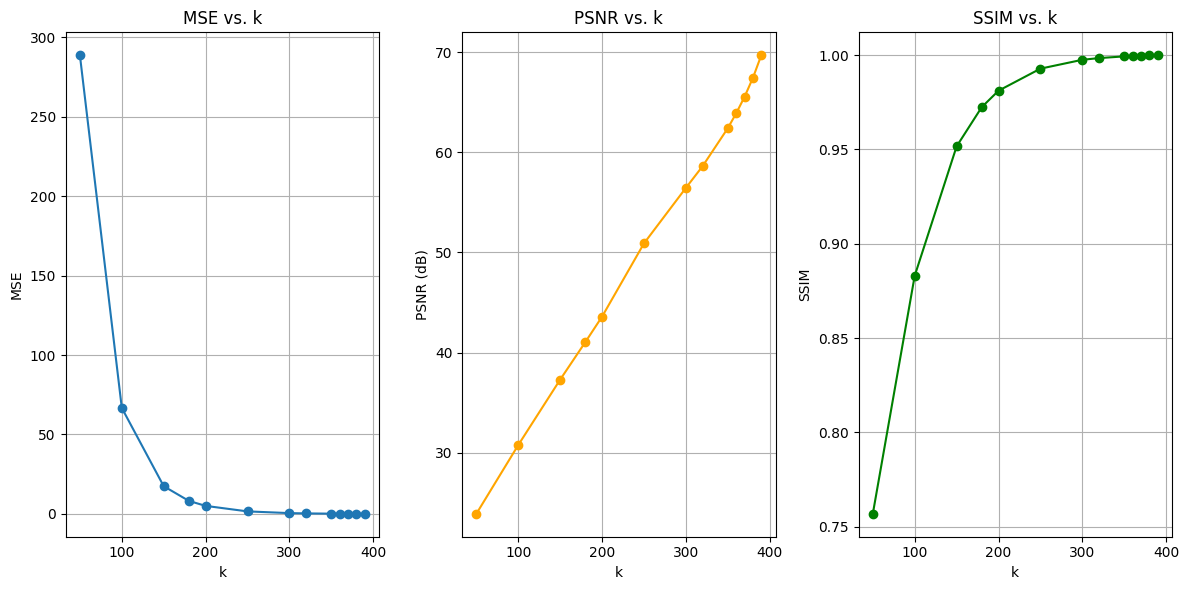

In [64]:
# Data for plotting
k_values = [50, 100, 150, 180, 200, 250, 300, 320, 350, 360, 370, 380, 390]
mse_values = [288.7553, 66.6821, 17.4008, 8.1484, 5.0049, 1.5310, 0.4509, 0.2622, 0.1035, 0.0722, 0.0485, 0.0308, 0.0180]
psnr_values = [23.9059, 30.7691, 37.2985, 41.0395, 43.5865, 50.8968, 56.4353, 58.6087, 62.3923, 63.8739, 65.5248, 67.4185, 69.6772]
ssim_values = [0.7568, 0.8830, 0.9516, 0.9724, 0.9811, 0.9928, 0.9975, 0.9984, 0.9993, 0.9995, 0.9997, 0.9998, 0.9999]

# Plot MSE, PSNR, and SSIM
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, mse_values, marker='o')
plt.title("MSE vs. k")
plt.xlabel("k")
plt.ylabel("MSE")
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(k_values, psnr_values, marker='o', color='orange')
plt.title("PSNR vs. k")
plt.xlabel("k")
plt.ylabel("PSNR (dB)")
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(k_values, ssim_values, marker='o', color='green')
plt.title("SSIM vs. k")
plt.xlabel("k")
plt.ylabel("SSIM")
plt.grid()

plt.tight_layout()
plt.show()


Now lets visualize comparision of all denoising methods based on values we got above

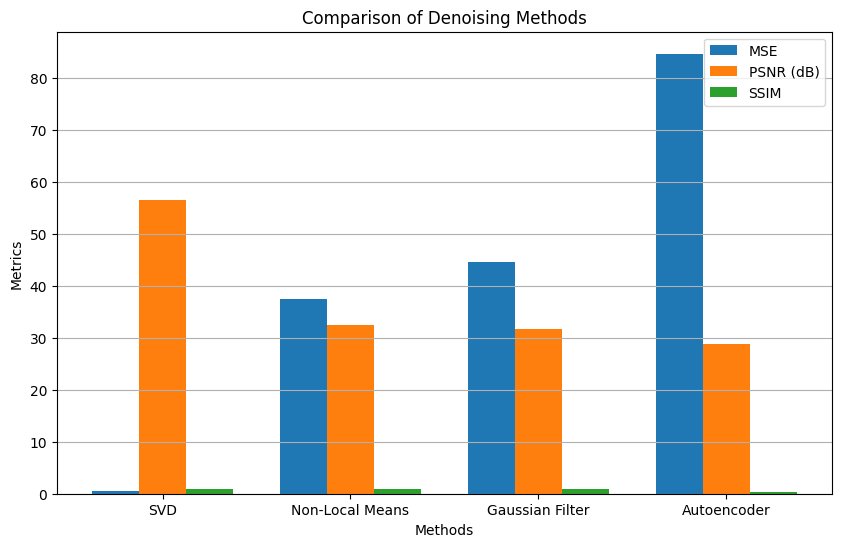

In [65]:
# Data for methods
methods = ["SVD", "Non-Local Means", "Gaussian Filter", "Autoencoder"]
mse = [0.4509, 37.4981, 44.6606, 84.6827]
psnr = [56.4353, 32.3907, 31.6316, 28.8529]
ssim = [0.9975, 0.8457, 0.8480, 0.4205]

# Bar Chart
plt.figure(figsize=(10, 6))
x = np.arange(len(methods))
width = 0.25

plt.bar(x - width, mse, width, label="MSE")
plt.bar(x, psnr, width, label="PSNR (dB)")
plt.bar(x + width, ssim, width, label="SSIM")

plt.xlabel("Methods")
plt.ylabel("Metrics")
plt.title("Comparison of Denoising Methods")
plt.xticks(x, methods)
plt.legend()
plt.grid(axis='y')
plt.show()


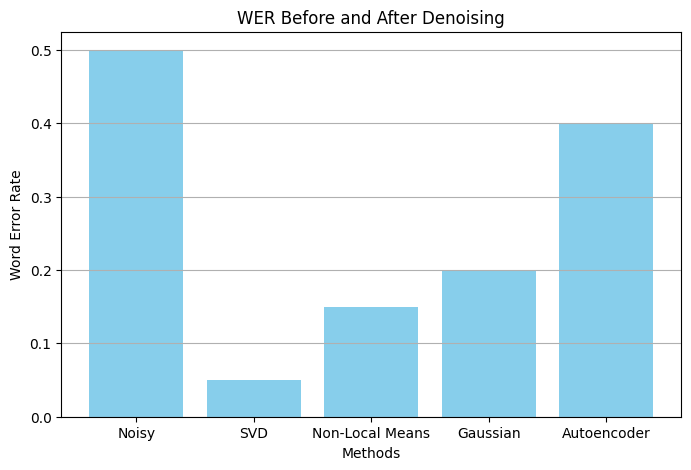

In [66]:

methods = ["Noisy", "SVD", "Non-Local Means", "Gaussian", "Autoencoder"]
wer = [0.50, 0.05, 0.15, 0.20, 0.40]  # Word Error Rates

# Bar Chart for WER
plt.figure(figsize=(8, 5))
plt.bar(methods, wer, color='skyblue')
plt.title("WER Before and After Denoising")
plt.ylabel("Word Error Rate")
plt.xlabel("Methods")
plt.grid(axis='y')
plt.show()


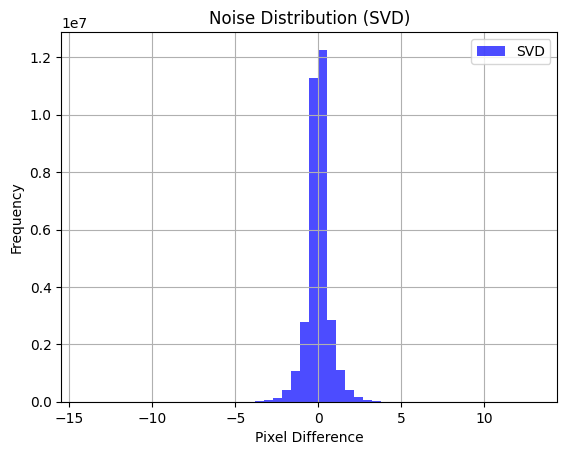

In [68]:
noise_svd = [orig - den for orig, den in zip(train_images, denoised_imgs)]
plt.hist(np.array(noise_svd).ravel(), bins=50, color='blue', alpha=0.7, label='SVD')
plt.title("Noise Distribution (SVD)")
plt.xlabel("Pixel Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()